# Putting it all together: Building a value-weighted index

## Imports

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Select index components & import data

### Explore and clean company listing information

In [51]:
listings = pd.read_csv('listings.csv')

In [52]:
# Inspect listings
print(listings.info())

# Move 'stock symbol' into the index
listings.set_index('Stock Symbol', inplace=True)

# Drop rows with missing 'sector' data
listings.dropna(subset=['Sector'], inplace=True)

# Select companies with IPO Year before 2019
listings = listings[listings['IPO Year'] < 2019]

# Inspect the new listings data
print(listings.info())

# Show the number of companies per sector
print(listings.groupby('Sector').size().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6674 entries, 0 to 6673
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               6674 non-null   object 
 1   Stock Symbol           6674 non-null   object 
 2   Company Name           6674 non-null   object 
 3   Last Sale              6590 non-null   float64
 4   Market Capitalization  6674 non-null   float64
 5   IPO Year               2852 non-null   float64
 6   Sector                 5182 non-null   object 
 7   Industry               5182 non-null   object 
dtypes: float64(3), object(5)
memory usage: 417.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               2349 non-null   object 
 1   Company Name           2349 non-null   object 
 2   

### Select and inspect index components

In [53]:
# Select largest company for each sector
components = listings.groupby(['Sector'])['Market Capitalization'].nlargest(1)

# Print components, sorted by market cap
print(components.sort_values(ascending=False))

# Select stock symbols and print the result
tickers = components.index.get_level_values('Stock Symbol')
print(tickers)

# Print company name, market cap, and last price for each component 
info_cols = ['Company Name', 'Market Capitalization', 'Last Sale']
print(listings.loc[tickers, info_cols].sort_values(by='Market Capitalization', ascending=False))

Sector                 Stock Symbol
Technology             AAPL            740024.467000
Consumer Services      AMZN            422138.530626
Miscellaneous          BABA            275525.000000
Health Care            AMGN            118927.210535
Transportation         UPS              90180.886756
Finance                GS               88840.590477
Consumer Non-Durables  ABEV             88240.198455
Basic Industries       RIO              70431.476895
Public Utilities       TEF              54609.806092
Capital Goods          GM               50086.335099
Energy                 PAA              22223.001416
Consumer Durables      CPRT             13620.922869
Name: Market Capitalization, dtype: float64
Index(['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF',
       'AAPL', 'UPS'],
      dtype='object', name='Stock Symbol')
                                    Company Name  Market Capitalization  \
Stock Symbol                                                   

### Import index component price information

In [54]:
tickers = tickers.tolist()

['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF', 'AAPL', 'UPS']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None


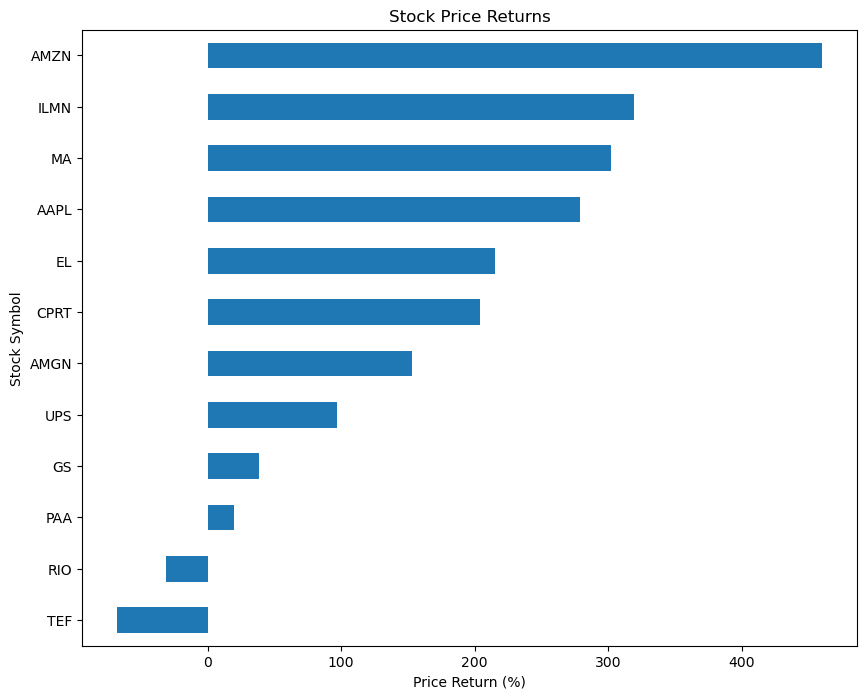

In [55]:
# Print tickers
print(tickers)

# Import prices and inspect result
stock_prices = pd.read_csv('stock_prices.csv', parse_dates=['Date'], index_col='Date')
print(stock_prices.info())

# Calculate the returns
price_return = 100* (stock_prices.iloc[-1, :] / stock_prices.iloc[0, :] - 1)

# Plot horizontal bar chart of sorted price_return   
price_return.sort_values().plot(kind='barh', figsize=(10, 8), title='Stock Price Returns')
plt.xlabel('Price Return (%)')
plt.ylabel('Stock Symbol')
plt.show()



## Build a market-cap weighted index

### Calculate number of shares outstanding

In [56]:
# Inspect listings and print tickers
print(listings.info())
print(tickers)

# Select components and relevant columns from listings
components = listings.loc[tickers, ['Market Capitalization', 'Last Sale']]

# Print the first rows of components
print(components.head(5))

# Calculate the number of shares here
no_shares = components['Market Capitalization'] / components['Last Sale']

# Print the sorted no_shares
print(no_shares.sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
Index: 2349 entries, ACU to ZTO
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Exchange               2349 non-null   object 
 1   Company Name           2349 non-null   object 
 2   Last Sale              2349 non-null   float64
 3   Market Capitalization  2349 non-null   float64
 4   IPO Year               2349 non-null   float64
 5   Sector                 2349 non-null   object 
 6   Industry               2349 non-null   object 
dtypes: float64(3), object(4)
memory usage: 211.4+ KB
None
['RIO', 'GM', 'CPRT', 'ABEV', 'AMZN', 'PAA', 'GS', 'AMGN', 'BABA', 'TEF', 'AAPL', 'UPS']
              Market Capitalization  Last Sale
Stock Symbol                                  
RIO                    70431.476895      38.94
GM                     50086.335099      33.39
CPRT                   13620.922869      29.65
ABEV                   88240.198455       5.62


### Create time series of market value

In [57]:
components['Number of Shares'] = no_shares

Stock Symbol
GS        397.817439
CPRT      459.390316
AMZN      477.170618
PAA       723.404994
AMGN      735.890171
UPS       869.297154
GM       1500.039985
RIO      1808.717948
BABA     2500.000000
TEF      5037.804990
AAPL     5246.540000
ABEV    15701.102928
Name: Number of Shares, dtype: float64


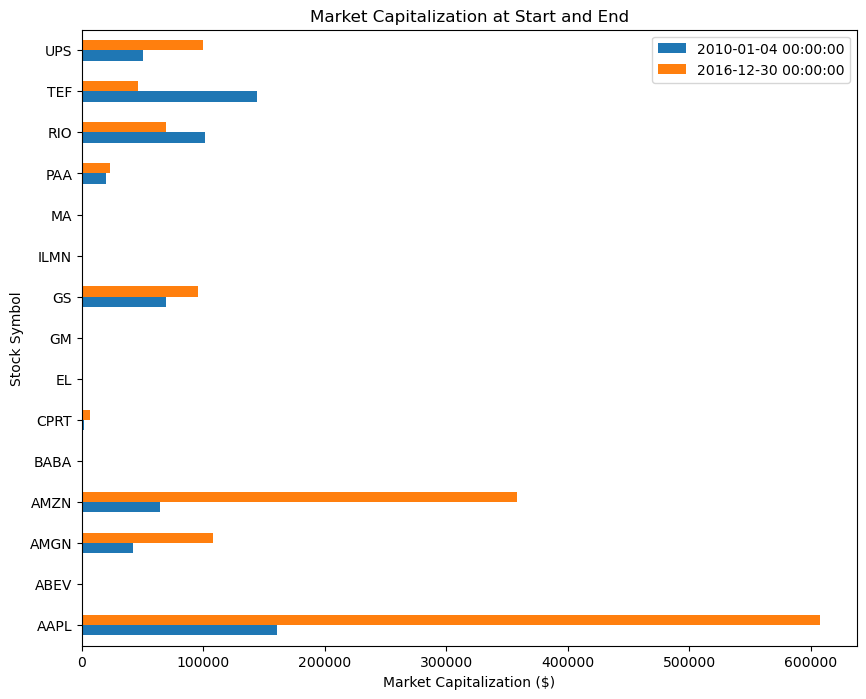

In [58]:
# Select the number of shares
no_shares = components['Number of Shares']
print(no_shares.sort_values())

# Create the series of market cap per ticker
market_cap = stock_prices * no_shares

# Select first and last market cap here
first_value = market_cap.iloc[0]
last_value = market_cap.iloc[-1]


# Concatenate and plot first and last market cap here
pd.concat([first_value, last_value], axis=1).plot(kind='barh', figsize=(10, 8), title='Market Capitalization at Start and End')
plt.ylabel('Stock Symbol')
plt.xlabel('Market Capitalization ($)')
plt.show()



### Calculate & plot the composite index

In [59]:
market_cap_series = pd.read_csv('market_cap_series.csv', parse_dates=['Date'], index_col='Date')

Date
2010-01-04    6.948176e+05
2010-01-05    6.979957e+05
2010-01-06    6.946857e+05
2010-01-07    6.912416e+05
2010-01-08    6.958476e+05
                  ...     
2016-12-23    1.588874e+06
2016-12-27    1.599280e+06
2016-12-28    1.593635e+06
2016-12-29    1.589422e+06
2016-12-30    1.574862e+06
Length: 1761, dtype: float64
Date
2010-01-04    100.000000
2010-01-05    100.457394
2010-01-06     99.981005
2010-01-07     99.485328
2010-01-08    100.148231
                 ...    
2016-12-23    228.675001
2016-12-27    230.172669
2016-12-28    229.360223
2016-12-29    228.753821
2016-12-30    226.658267
Length: 1761, dtype: float64


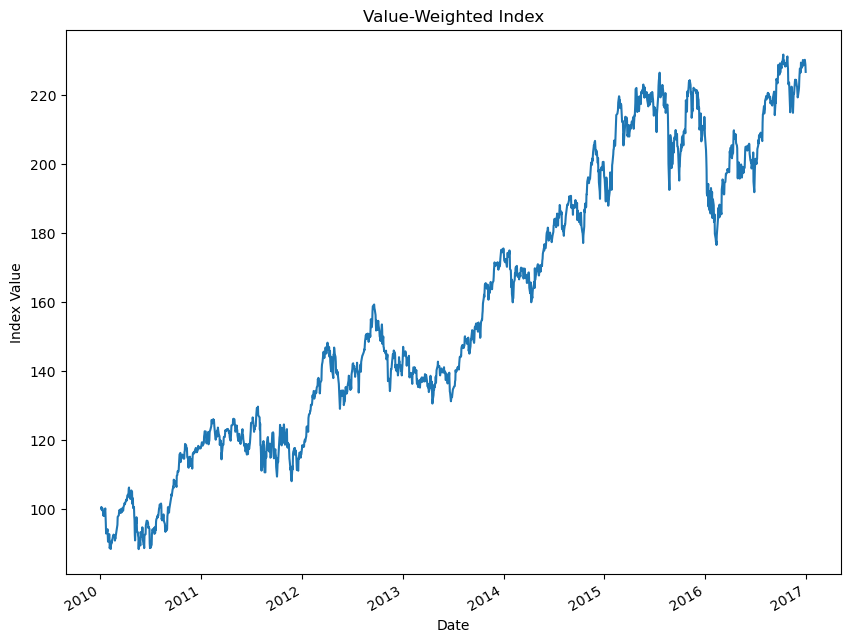

In [62]:
# Aggregate and print the market cap per trading day
raw_index = market_cap_series.sum(axis=1)
print(raw_index)

# Normalize the aggregate market cap here 
index = raw_index / raw_index.iloc[0] * 100
print(index)

# Plot the index here
index.plot(figsize=(10, 8), title='Value-Weighted Index')
plt.ylabel('Index Value')
plt.xlabel('Date')
plt.show()


## Evaluate index performance

### Calculate the contribution of each stock to the index

126.65826661173818
Stock Symbol
CPRT    0.006694
PAA     0.010921
GM      0.024614
TEF     0.026837
RIO     0.034613
ABEV    0.043365
GS      0.043660
UPS     0.044318
AMGN    0.058445
BABA    0.135403
AMZN    0.207455
AAPL    0.363675
Name: Market Capitalization, dtype: float64


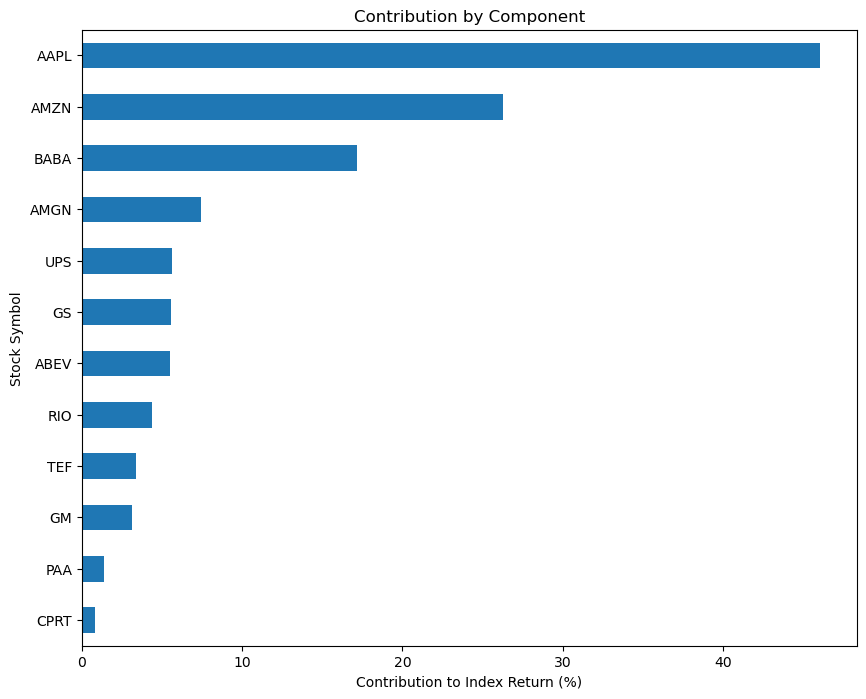

In [66]:
# Calculate and print the index return here
index_return = (index.iloc[-1] / index.iloc[0] - 1) * 100
print(index_return)

# Select the market capitalization
market_cap = components['Market Capitalization']

# Calculate the total market cap
total_market_cap = market_cap.sum()

# Calculate the component weights, and print the result
weights = market_cap / total_market_cap
print(weights.sort_values())

# Calculate and plot the contribution by component
weights.mul(index_return).sort_values().plot(kind='barh', figsize=(10, 8), title='Contribution by Component')
plt.xlabel('Contribution to Index Return (%)')
plt.ylabel('Stock Symbol')
plt.show()


### Compare index performance against benchmark I

In [70]:
djia = pd.read_csv('djia.csv', parse_dates=['date'], index_col='date')

Index    126.658267
DJIA      86.722172
dtype: float64


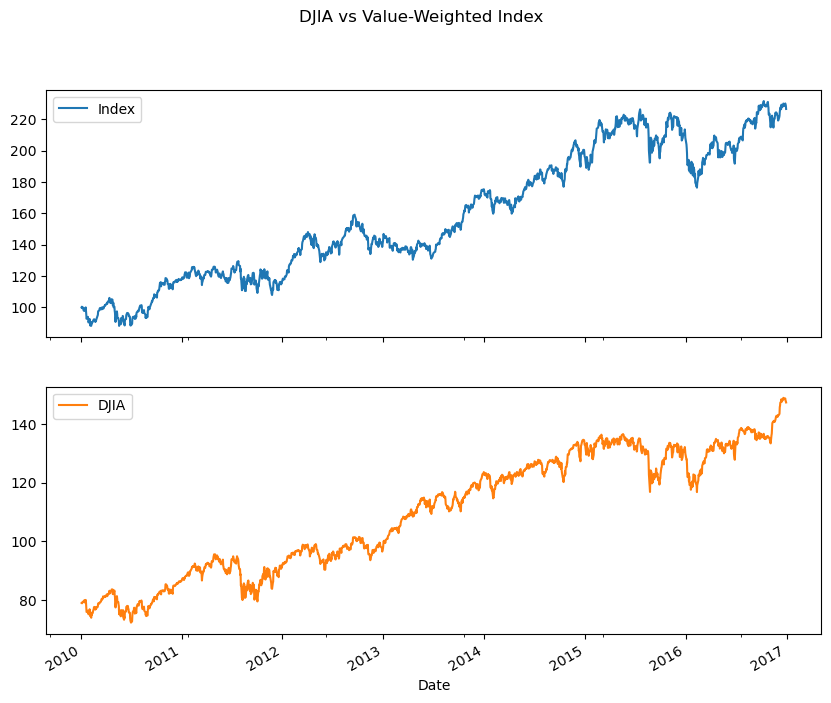

In [87]:
# Convert index series to dataframe here
data = index.to_frame(name='Index')

# Normalize djia series and add as new column to data
djia = djia / djia.iloc[0] * 100
data['DJIA'] = djia

# # Show total return for both index and djia
print((data.iloc[-1] / data.iloc[0] - 1)* 100)

# Plot both series
data.plot(figsize=(10, 8), title='DJIA vs Value-Weighted Index', subplots=True)
plt.show()


### Compare index performance against benchmark II

In [91]:
data = data / data.iloc[0] * 100

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1761 non-null   float64
 1   DJIA    1761 non-null   float64
dtypes: float64(2)
memory usage: 41.3 KB
None
                 Index        DJIA
Date                              
2010-01-04  100.000000  100.000000
2010-01-05  100.457394   99.887188
2010-01-06   99.981005   99.902872
2010-01-07   99.485328  100.216365
2010-01-08  100.148231  100.323414


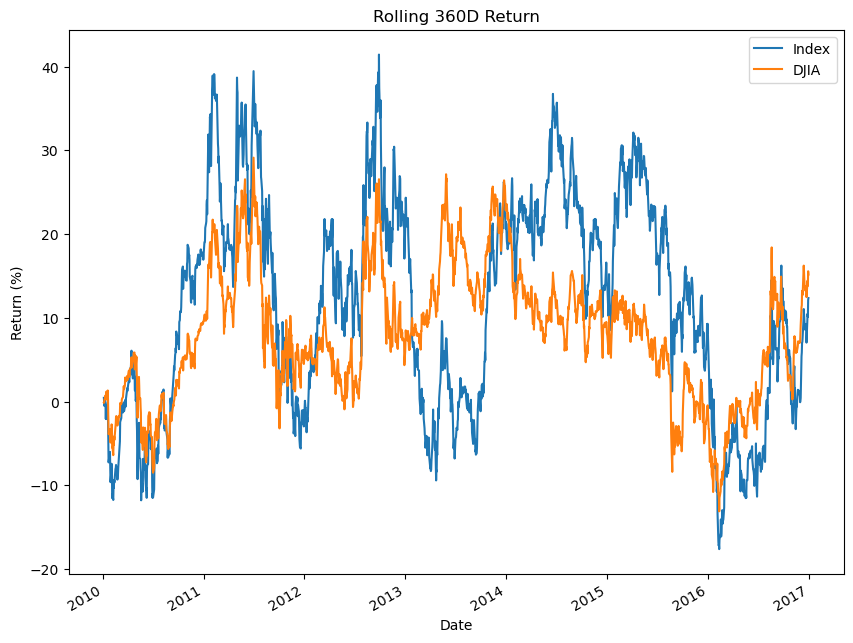

In [92]:
# Inspect data
print(data.info())
print(data.head(5))

# Create multi_period_return function here
def multi_period_return(r):
    return (np.prod(1 + r) - 1) * 100

# Calculate rolling_return_360
rolling_return_360 = data.pct_change().rolling(window='360D').apply(multi_period_return)

# Plot rolling_return_360 here
rolling_return_360.plot(figsize=(10, 8), title='Rolling 360D Return', ylabel='Return (%)')
plt.show()


## Index correlation & exporting to Excel

### Visualize your index constituent correlations

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
          AAPL      AMGN      AMZN      CPRT        EL        GS      ILMN  \
AAPL  1.000000  0.286898  0.327611  0.346616  0.306770  0.344981  0.264791   
AMGN  0.286898  1.000000  0.323408  0.355892  0.349893  0.390076  0.336927   
AMZN  0.327611  0.323408  1.000000  0.298929  0.334031  0.333402  0.242726 

/tmp/ipykernel_897383/1486132891.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = stock_prices.pct_change()


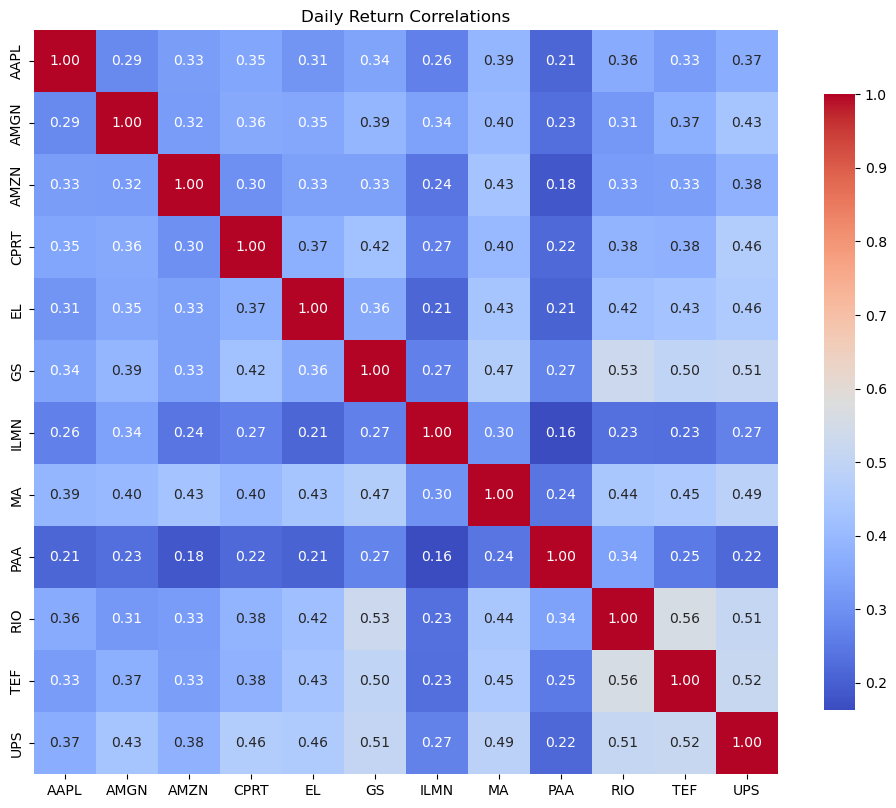

In [96]:
# Inspect stock_prices here
print(stock_prices.info())

# Calculate the daily returns
returns = stock_prices.pct_change()

# Calculate and print the pairwise correlations
correlations = returns.corr()
print(correlations)

# Plot a heatmap of daily return correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Daily Return Correlations')
plt.show()



### Save your analysis to multiple excel worksheets

In [101]:
index = index.to_frame(name='Index')

In [103]:
# Inspect index and stock_prices
print(index.info())
print(stock_prices.info())

# Join index to stock_prices, and inspect the result
data = stock_prices.join(index)
print(data.info())

# Create index & stock price returns
returns = data.pct_change()

# Export data and data as returns to excel
with pd.ExcelWriter('data.xlsx') as writer:
    data.to_excel(writer, sheet_name='data')
    returns.to_excel(writer, sheet_name='returns')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2010-01-04 to 2016-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   1761 non-null   float64
dtypes: float64(1)
memory usage: 27.5 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    1761 non-null   float64
 1   AMGN    1761 non-null   float64
 2   AMZN    1761 non-null   float64
 3   CPRT    1761 non-null   float64
 4   EL      1762 non-null   float64
 5   GS      1762 non-null   float64
 6   ILMN    1761 non-null   float64
 7   MA      1762 non-null   float64
 8   PAA     1762 non-null   float64
 9   RIO     1762 non-null   float64
 10  TEF     1762 non-null   float64
 11  UPS     1762 non-null   float64
dtypes: float64(12)
memory usage: 179.0 KB
None
<class 'pandas.core.frame.Da

/tmp/ipykernel_897383/1093536577.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change()
